## 商品SKU元数据整合与归类

对电商类型的产品进行关键词提取，主要思想是：参考对文本类型数据的方式，将电商产品的所有详细描述组合成一个文本，然后利用一些关键词提取技术来提取关键词，如TF·IDF、TextRank等等，又或者直接分词

因此，为了便于处理，我们需要首先将要用来提取关键词(标签)的数据全部整合出来放到一张表中


#### 结论：

整合完后的dataframe -> 临时注册表 ->spark.sql使用hql语句创建hive表、插入数据 -> 存到hdfs

SKU-stock keeping unit即“库存量单位”-最小可用单位：  
SKU是指一款商品，每款都有出现一个SKU，便于电商品牌识别商品；  
一款商品多色，则是有多个SKU


In [1]:
import os
# 配置pyspark和spark driver运行时 使用的python解释器
JAVA_HOME = '/root/bigdata/jdk'
PYSPARK_PYTHON = '/miniconda2/envs/py365/bin/python'
# 当存在多个版本时，不指定很可能会导致出错
os.environ['PYSPARK_PYTHON'] = PYSPARK_PYTHON
os.environ['PYSPARK_DRIVER_PYTHON'] = PYSPARK_PYTHON
os.environ['JAVA_HOME'] = JAVA_HOME
# 配置spark信息
from pyspark import SparkConf
from pyspark.sql import SparkSession

SPARK_APP_NAME = "processingSKUMetadata"
SPARK_URL = "spark://192.168.58.100:7077"

conf = SparkConf()    # 创建spark config对象
config = (
	("spark.app.name", SPARK_APP_NAME),    # 设置启动的spark的app名称，没有提供，将随机产生一个名称
	("spark.executor.memory", "2g"),    # 设置该app启动时占用的内存用量，默认1g，指一台虚拟机
	("spark.master", SPARK_URL),    # spark master的地址
    ("spark.executor.cores", "2"),    # 设置spark executor使用的CPU核心数，指一台虚拟机
    ("hive.metastore.uris", "thrift://localhost:9083"),    # 配置hive元数据的访问，否则spark无法获取hive中已存储的数据
    
    # 以下三项配置，可以控制执行器数量
#     ("spark.dynamicAllocation.enabled", True),
#     ("spark.dynamicAllocation.initialExecutors", 1),    # 1个执行器
#     ("spark.shuffle.service.enabled", True)
# 	('spark.sql.pivotMaxValues', '99999'),  # 当需要pivot DF，且值很多时，需要修改，默认是10000
)
# 查看更详细配置及说明：https://spark.apache.org/docs/latest/configuration.html

conf.setAll(config)

# 利用config对象，创建spark session
spark = SparkSession.builder.config(conf=conf).enableHiveSupport().getOrCreate()
# 不开启hive，不能使用spark.sql("sql语句")
# spark = SparkSession.builder.config(conf=conf).getOrCreate()

#### 查看当前商品元数据表

In [7]:
spark.catalog.listTables('default')

[Table(name='employee', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='sku_detail', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='sku_tag_weights', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='student', database='default', description=None, tableType='MANAGED', isTemporary=False),
 Table(name='tb_goods', database='default', description='Imported by sqoop on 2020/11/09 14:02:49', tableType='MANAGED', isTemporary=False),
 Table(name='tb_goods_category', database='default', description='Imported by sqoop on 2020/11/09 14:03:21', tableType='MANAGED', isTemporary=False),
 Table(name='tb_goods_specification', database='default', description='Imported by sqoop on 2020/11/09 14:04:11', tableType='MANAGED', isTemporary=False),
 Table(name='tb_sku', database='default', description='Imported by sqoop on 2020/11/09 14:04:53', tableType='MANAGED', isTemporary=Fal

In [2]:
print("tb_goods表：")
spark.sql("select count(*) tb_goods  from tb_goods").show()
spark.sql("select * from tb_goods").show()
print("tb_goods_category表：")
spark.sql("select count(*) tb_goods_category from tb_goods_category").show()
spark.sql("select * from tb_goods_category").show()
print("tb_goods_specification表：")
spark.sql("select count(*) tb_goods_specification from tb_goods_specification").show()
spark.sql("select * from tb_goods_specification").show()
print("tb_sku_specification表：")
spark.sql("select count(*) tb_sku_specification from tb_sku_specification").show()
spark.sql("select * from tb_sku_specification").show()
print("tb_sku表：")
spark.sql("select count(*) tb_sku from tb_sku").show()
spark.sql("select * from tb_sku").show()
print("tb_specification_option表：")
spark.sql("select count(*) tb_specification_option from tb_specification_option").show()
spark.sql("select * from tb_specification_option").show()

tb_goods表：
+--------+
|tb_goods|
+--------+
|  326160|
+--------+

+---+--------------------+--------------------+--------------------+-----+--------+--------+------------+------------+------------+--------------------+--------------------+--------------------+
| id|         create_time|         update_time|                name|sales|comments|brand_id|category1_id|category2_id|category3_id|         desc_detail|           desc_pack|        desc_service|
+---+--------------------+--------------------+--------------------+-----+--------+--------+------------+------------+------------+--------------------+--------------------+--------------------+
|  1|2018-04-11 16:01:...|2018-04-25 12:09:...|Apple MacBook Pro...|    1|       1|       1|           4|          45|         157|<h1 style="text-a...|<h2>包装清单</h2><p>M...|<p>&nbsp;<strong>...|
|  2|2018-04-14 02:09:...|2018-04-25 11:51:...| Apple iPhone 8 Plus|    3|       1|       1|           1|          38|         115|<p><img alt="" sr...|<

+------+
|tb_sku|
+------+
|326173|
+------+

+---+--------------------+--------------------+--------------------+--------------------+-------+----------+------------+-----+-----+--------+-----------+-----------+--------+--------------------+
| id|         create_time|         update_time|                name|             caption|  price|cost_price|market_price|stock|sales|comments|is_launched|category_id|goods_id|   default_image_url|
+---+--------------------+--------------------+--------------------+--------------------+-------+----------+------------+-----+-----+--------+-----------+-----------+--------+--------------------+
|  1|2018-04-11 17:28:...|2018-04-25 11:09:...|Apple MacBook Pro...|【全新2017款】MacBook ...|11388.0|   10350.0|     13388.0|    5|    5|       1|       true|        157|       1|http://image.meid...|
|  2|2018-04-12 06:53:...|2018-04-23 11:44:...|Apple MacBook Pro...|【全新2017款】MacBook ...|11398.0|   10388.0|     13398.0|    0|    1|       0|       true|        157|

In [15]:
print('tb_goods')
spark.sql("select * from tb_goods").printSchema()
print('tb_goods_category')
spark.sql("select * from tb_goods_category").printSchema()
print('tb_goods_specification')
spark.sql("select * from tb_goods_specification").printSchema()
print('tb_sku_specification')
spark.sql("select * from tb_sku_specification").printSchema()
print('tb_sku')
spark.sql("select * from tb_sku").printSchema()
print('tb_specification_option')
spark.sql("select * from tb_specification_option").printSchema()

tb_goods
root
 |-- id: integer (nullable = true)
 |-- create_time: string (nullable = true)
 |-- update_time: string (nullable = true)
 |-- name: string (nullable = true)
 |-- sales: integer (nullable = true)
 |-- comments: integer (nullable = true)
 |-- brand_id: integer (nullable = true)
 |-- category1_id: integer (nullable = true)
 |-- category2_id: integer (nullable = true)
 |-- category3_id: integer (nullable = true)
 |-- desc_detail: string (nullable = true)
 |-- desc_pack: string (nullable = true)
 |-- desc_service: string (nullable = true)

tb_goods_category
root
 |-- id: integer (nullable = true)
 |-- create_time: string (nullable = true)
 |-- update_time: string (nullable = true)
 |-- name: string (nullable = true)
 |-- parent_id: integer (nullable = true)

tb_goods_specification
root
 |-- id: integer (nullable = true)
 |-- create_time: string (nullable = true)
 |-- update_time: string (nullable = true)
 |-- name: string (nullable = true)
 |-- goods_id: integer (nullable = tr

#### 电商六张表之间的关系
https://blog.csdn.net/pythonstrat/article/details/108081203

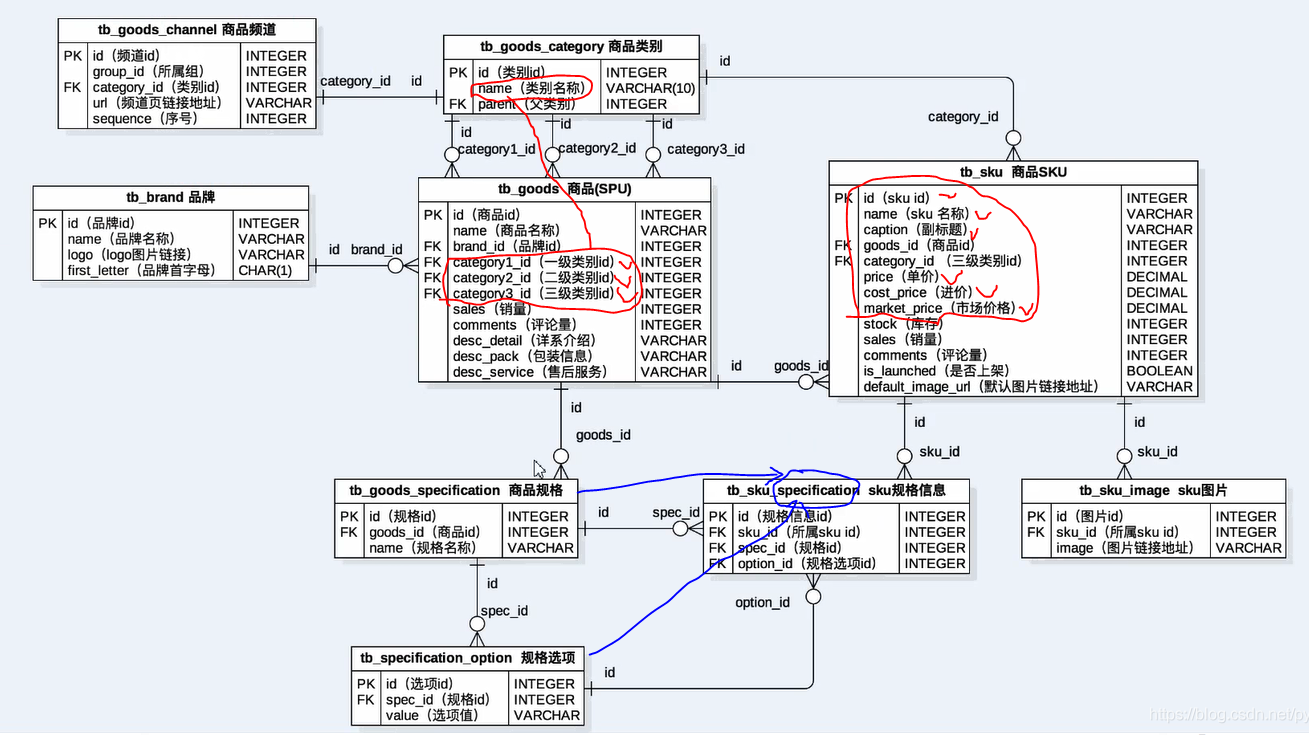

#### 分析：需要用到哪些数据？  
目标：以tb_sku表为基础，将其他信息合并  
合并后保留字段：sku_id | name | caption | category1_id | category2_id | category3_id | price | cost_price | market_price | specification | category1 | category2 | category3  
- sku_id | name | caption | price | cost_price | market_price | goods_id 来自tb_sku表
- category1_id | category2_id | category3_id 来自tb_goods表 
- category1 | category2 | category3 根据tb_goods表中的类别ID 找到tb_goods_category表中的类别名 获得
- specification字段 将以tb_sku_specifition表 对照tb_goods_specification表和tb_specification_option表获得  

商品推荐 将以SKU为最小单位


#### 2.1.1连接tb_sku表和tb_goods表

In [33]:
spark.sql('select * from tb_goods_category').show(2)

+---+--------------------+--------------------+----+---------+
| id|         create_time|         update_time|name|parent_id|
+---+--------------------+--------------------+----+---------+
|  1|2018-04-09 08:03:...|2018-04-09 08:03:...|  手机|     null|
|  2|2018-04-09 08:04:...|2018-04-09 08:04:...|  相机|     null|
+---+--------------------+--------------------+----+---------+
only showing top 2 rows



In [141]:
sql1='''
select a.id sku_id,name,caption,goods_id,price,cost_price,market_price,category1_id,category2_id,category3_id from tb_sku a
join 
(select category1_id,category2_id,category3_id,id from tb_goods b)
on a.goods_id=b.id
'''
tmp1 = spark.sql(sql1)

#### 匹配1，2，3分类的中文描述

In [ ]:
# 方式1：利用sql语句的方式
# =========仅用于对比两种方式，跳过该cell，不要运行，就当是没有这个cell！！========
sql3 = '''
select * from(
    select a.id sku_id,name, caption, price, cost_price, market_price, goods_id, category1_id, category2_id, category3_id 
    from 
    tb_sku as a
    join
    (select id, category1_id, category2_id, category3_id from tb_goods as b)
    where a.goods_id=b.id
) as tb
join
(select id, name category1 from tb_goods_category as c)
where tb.category1_id=c.id
'''
# 这里把一级分类匹配上
spark.sql(sql3).show()
# 但如果还要继续匹配二级三级，使用sql语句的话，代码可读性很差，因此这里最终使用dataframe的api来完成分类剩余的sql操作


In [142]:
# 方式2：利用dataframe的sql化API方式
sql1='''
select a.id sku_id,name,caption,goods_id,price,cost_price,market_price,category1_id,category2_id,category3_id from tb_sku a
join 
(select category1_id,category2_id,category3_id,id from tb_goods b)
on a.goods_id=b.id
'''
tmp1 = spark.sql(sql1)

goods_category_df = spark.sql('select id,name category1 from tb_goods_category')
tmp1=tmp1.join(goods_category_df,[tmp1.category1_id==goods_category_df.id])

goods_category_df = spark.sql('select id,name category2 from tb_goods_category')
tmp1=tmp1.join(goods_category_df,[tmp1.category2_id==goods_category_df.id])

goods_category_df = spark.sql('select id,name category3 from tb_goods_category')
tmp1=tmp1.join(goods_category_df,[tmp1.category3_id==goods_category_df.id])
# tmp1.columns
tmp1 = tmp1.select('goods_id','sku_id','name', 'caption','price','cost_price','market_price','category1_id','category1','category2_id','category2','category3_id','category3')
tmp1.show()

+--------+------+--------------------+--------------------+-------+----------+------------+------------+---------+------------+---------+------------+---------+
|goods_id|sku_id|                name|             caption|  price|cost_price|market_price|category1_id|category1|category2_id|category2|category3_id|category3|
+--------+------+--------------------+--------------------+-------+----------+------------+------------+---------+------------+---------+------------+---------+
|       1|     1|Apple MacBook Pro...|【全新2017款】MacBook ...|11388.0|   10350.0|     13388.0|           4|       电脑|          45|     电脑整机|         157|      笔记本|
|       1|     2|Apple MacBook Pro...|【全新2017款】MacBook ...|11398.0|   10388.0|     13398.0|           4|       电脑|          45|     电脑整机|         157|      笔记本|
|       2|     3|Apple iPhone 8 Pl...|选【移动优惠购】新机配新卡，198...| 6499.0|    6300.0|      6598.0|           1|       手机|          38|     手机通讯|         115|       手机|
|       2|     4|Apple iPhone 8 Pl

In [143]:
tmp1.columns

['goods_id',
 'sku_id',
 'name',
 'caption',
 'price',
 'cost_price',
 'market_price',
 'category1_id',
 'category1',
 'category2_id',
 'category2',
 'category3_id',
 'category3']

#### 匹配每一个SKU的specification并选出对应的文字描述

In [137]:
# tb_sku_specification 与 tb_goods_specification 两表相连
sql2='''
select sku_id,spec_id,option_id,specification from tb_sku_specification a
join
(select id,name specification from tb_goods_specification b)
on a.spec_id=b.id
'''
# spark.sql(sql2).show()
# 上表依照tb_sku_specification 与 tb_specification_option 表相连
sql3='''
select sku_id,specification,option from
(select sku_id,spec_id,option_id,specification from tb_sku_specification a
join
(select id,name specification from tb_goods_specification b)
on a.spec_id=b.id) as tb
join
(select value option,id from tb_specification_option c)
on tb.option_id=c.id
'''
tmp2=spark.sql(sql3).sort('sku_id')
tmp2.show()
# 可以查看某个sku_id都有具体都有哪些
# tmp2.registerTempTable('table1')
# spark.sql('select * from table1 where sku_id=17').show(truncate=False)

+------+-------------+-------------------+
|sku_id|specification|             option|
+------+-------------+-------------------+
|     1|           颜色|                 银色|
|     1|           版本|core i5/8G内存/512G存储|
|     1|         屏幕尺寸|             13.3英寸|
|     2|           颜色|                深灰色|
|     2|           版本|core i5/8G内存/512G存储|
|     2|         屏幕尺寸|             13.3英寸|
|     3|           颜色|                 金色|
|     3|           内存|               64GB|
|     4|           颜色|                 金色|
|     4|           内存|              256GB|
|     5|           颜色|                深空灰|
|     5|           内存|               64GB|
|     6|           颜色|                深空灰|
|     6|           内存|              256GB|
|     7|           颜色|                 银色|
|     7|           内存|               64GB|
|     8|           内存|              256GB|
|     8|           颜色|                 银色|
|     9|           版本|               64GB|
|     9|           颜色|                钻雕金|
+------+---

#### 将刚才sql2的结果以SKU为单位进行合并

- 先使用sql的concat方法可以对列进行合并

- 然后对数据进行group by后使用collect_set进行聚合操作，收集每一列非重复数据，再用concat或concat_ws方法对列进行合并


以下是代码是sql语句用法，对于spark中dataframe的方法，可参见:
- [pyspark.sql.functions.concat](https://spark.apache.org/docs/2.2.2/api/python/pyspark.sql.html?highlight=concat#pyspark.sql.functions.concat)
- [pyspark.sql.functions.concat_ws](https://spark.apache.org/docs/2.2.2/api/python/pyspark.sql.html?highlight=concat#pyspark.sql.functions.concat_ws)
- [pyspark.sql.functions.collect_set](https://spark.apache.org/docs/2.2.2/api/python/pyspark.sql.html?highlight=concat#pyspark.sql.functions.collect_set)


In [138]:
# 对上表进行操作，目标：sku other字段 共两个字段
# 对上表进行 列拼接
sql4='''
select sku_id,concat(specification,':',option) temp from
(select sku_id,spec_id,option_id,specification from tb_sku_specification a
join
(select id,name specification from tb_goods_specification b)
on a.spec_id=b.id) as tb
join
(select value option,id from tb_specification_option c)
on tb.option_id=c.id
'''
# spark.sql(sql4).orderBy('sku_id').show(truncate=False)
#上表操作，目标：相同sku_id合并成一个
sql5='''
select sku_id,concat_ws(',',sort_array(collect_set(temp))) specification from 
(select sku_id,concat(specification,':',option) temp from
(select sku_id,spec_id,option_id,specification from tb_sku_specification a
join
(select id,name specification from tb_goods_specification b)
on a.spec_id=b.id) as tb
join
(select value option,id from tb_specification_option c)
on tb.option_id=c.id)
group by sku_id
'''
tmp2 = spark.sql(sql5).orderBy('sku_id')
tmp2.show()

+------+--------------------+
|sku_id|       specification|
+------+--------------------+
|     1|屏幕尺寸:13.3英寸,版本:co...|
|     2|屏幕尺寸:13.3英寸,版本:co...|
|     3|       内存:64GB,颜色:金色|
|     4|      内存:256GB,颜色:金色|
|     5|      内存:64GB,颜色:深空灰|
|     6|     内存:256GB,颜色:深空灰|
|     7|       内存:64GB,颜色:银色|
|     8|      内存:256GB,颜色:银色|
|     9|      版本:64GB,颜色:钻雕金|
|    10|     版本:128GB,颜色:钻雕金|
|    11|     版本:128GB,颜色:钻雕蓝|
|    12|      版本:64GB,颜色:钻雕蓝|
|    13|      版本:64GB,颜色:玫瑰金|
|    14|     版本:128GB,颜色:玫瑰金|
|    15|      版本:64GB,颜色:曜石黑|
|    16|     版本:128GB,颜色:曜石黑|
|    17|颜色:大屏5.5中国红(8p/7p...|
|    18|版本:hero7 black黑色(...|
|    20|   颜色:白色,颜色:粉色,颜色:黑色|
|    21|颜色:白色无线充+29瓦适配器,颜...|
+------+--------------------+
only showing top 20 rows



#### 对前面的两个结果进行合并，获得最终sku_detail表

In [174]:
# 将商品sku和sku规格信息进行拼接 即tmp1和tmp2连接
# 注意：有些商品sku没有规格信息，因此需要将两张表进行outer连接
tmp2=tmp2.withColumnRenamed('sku_id','sku_id2')
sku_detail = tmp1.join(tmp2,[tmp1.sku_id==tmp2.sku_id2],'outer')
sku_detail=sku_detail.select([c for c in sku_detail.columns if c != 'sku_id2'])
sku_detail.show()

+--------+------+--------------------+--------------------+------+----------+------------+------------+---------+------------+---------+------------+---------+--------------------+
|goods_id|sku_id|                name|             caption| price|cost_price|market_price|category1_id|category1|category2_id|category2|category3_id|category3|       specification|
+--------+------+--------------------+--------------------+------+----------+------------+------------+---------+------------+---------+------------+---------+--------------------+
|     135|   148|随身厅 WPOS-3 高度集成业务...|      享包邮！正品保证，购物无忧！|2999.0|    2999.0|      2999.0|           3|       数码|          41|     数码配件|         140|      读卡器|                null|
|     451|   463|飞花令 安卓手机读卡器Type-c...|您身边的私人定制：【联系客服告知型...|   7.8|       7.8|         7.8|           3|       数码|          41|     数码配件|         140|      读卡器|颜色:Type-C TF卡 读卡器...|
|     458|   471|【包邮】飞花令 安卓外置手机读卡器...|micro usb/V8 TF卡读...|  15.8|      15.8|        15.8|     

### 以上获得最终sku_detail表的所有代码 可以写入该cell
```python
# a.category合并
sql2 = '''
select a.id sku_id, name, caption, price, cost_price, market_price, goods_id, category1_id, category2_id, category3_id 
from 
tb_sku as a
join
(select id, category1_id, category2_id, category3_id from tb_goods as b)
where a.goods_id=b.id
'''

ret = spark.sql(sql2)
# 合并一级分类
cate_df = spark.sql("select id, name category1 from tb_goods_category")
ret = ret.join(cate_df,[ret.category1_id==cate_df.id])

# 合并二级分类
cate_df = spark.sql("select id, name category2 from tb_goods_category")
ret = ret.join(cate_df,[ret.category2_id==cate_df.id])

# 合并三级分类
cate_df = spark.sql("select id, name category3 from tb_goods_category")
ret = ret.join(cate_df,[ret.category3_id==cate_df.id])

# b.
sql5 =  '''
select sku_id, concat_ws(",", sort_array(collect_set(temp))) as specification  from (
    select sku_id, concat(specification,":",option) as temp from (
        select option_id, sku_id, a.spec_id, option from tb_sku_specification as a 
        join 
        (select id, value option from tb_specification_option as b ) 
        where a.option_id=b.id
    ) as tb 
    join 
    (select id, name specification from tb_goods_specification as c)
    where tb.spec_id=c.id
) group by sku_id
'''
# 避免sku_id冲突，这里改写一下名称
specification_df = spark.sql(sql5).withColumnRenamed("sku_id", "sku_id2")

sku_detail = ret.join(specification_df, ret.sku_id==specification_df.sku_id2, "outer")

sku_detail = sku_detail.select("goods_id,sku_id,category1_id,category1,category2_id,category2,category3_id,category3,name,caption,price,cost_price,market_price,specification".split(","))

sku_detail.show()
```

#### 将合并好的sku_detail数据写入hive表

In [175]:
# 将spark的dataframe注册为临时表，以便能对其使用sql语句
sku_detail.registerTempTable('tempTable')
# 查看临时表结构
spark.sql('desc tempTable').show()

+-------------+---------+-------+
|     col_name|data_type|comment|
+-------------+---------+-------+
|     goods_id|      int|   null|
|       sku_id|      int|   null|
|         name|   string|   null|
|      caption|   string|   null|
|        price|   double|   null|
|   cost_price|   double|   null|
| market_price|   double|   null|
| category1_id|      int|   null|
|    category1|   string|   null|
| category2_id|      int|   null|
|    category2|   string|   null|
| category3_id|      int|   null|
|    category3|   string|   null|
|specification|   string|   null|
+-------------+---------+-------+



In [180]:
# 创建表结构  已经开启了hive sql功能
# 'sku_detail'两侧的符号不是单引号''，而是``
spark.sql("drop table if exists `sku_detail` ")
sql='''
create table `sku_detail`(
goods_id int,
sku_id int,
name string,
caption string,
price double,
cost_price double,
market_price double,
category1_id int,
category1 string,
category2_id int,
category2 string,
category3_id int,
category3 string,
specification string
)
'''
spark.sql(sql)

DataFrame[]

In [181]:
# 上一步建立好了表结构，现在往表中写数据
spark.sql("insert into sku_detail select * from tempTable")

DataFrame[]

此时访问: http://改为HadoopIP:50070/explorer.html#/user/hive/warehouse 可以查看hdfs上存储的sku_detail表

In [182]:
spark.sql('select * from sku_detail').count()

326173

In [189]:
spark.sql('select * from sku_detail ').show()
# 查看specification不是空的行
# spark.sql('select * from sku_detail  where specification is not null').show()

+--------+------+--------------------+--------------------+------+----------+------------+------------+---------+------------+---------+------------+---------+--------------------+
|goods_id|sku_id|                name|             caption| price|cost_price|market_price|category1_id|category1|category2_id|category2|category3_id|category3|       specification|
+--------+------+--------------------+--------------------+------+----------+------------+------------+---------+------------+---------+------------+---------+--------------------+
|     135|   148|随身厅 WPOS-3 高度集成业务...|      享包邮！正品保证，购物无忧！|2999.0|    2999.0|      2999.0|           3|       数码|          41|     数码配件|         140|      读卡器|                null|
|     451|   463|飞花令 安卓手机读卡器Type-c...|您身边的私人定制：【联系客服告知型...|   7.8|       7.8|         7.8|           3|       数码|          41|     数码配件|         140|      读卡器|颜色:Type-C TF卡 读卡器...|
|     458|   471|【包邮】飞花令 安卓外置手机读卡器...|micro usb/V8 TF卡读...|  15.8|      15.8|        15.8|     